# **Evapotranspiration Modeling using different Machine Learning Algorithms**

**LOAD, INSPECT, and CLEAN DATASET**

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Step 1: Load file
df_raw = pd.read_excel("Result_ETr 2022-2023_Hourly.xlsx", header=None)
df_raw.columns = df_raw.iloc[2]
df = df_raw.drop(index=[0, 1, 2, 3]).reset_index(drop=True)

# Step 2: Rename
df = df.rename(columns={
    'Mo': 'Month', 'Day': 'Day', 'Yr': 'Year', 'DoY': 'DayOfYear',
    'HrMn': 'HourMinute', 'Tmax': 'Tmax_C', 'Tmin': 'Tmin_C',
    'Rn': 'SolarRad_Wm2', 'Wind': 'WindSpeed_ms',
    'DewP': 'DewPoint_C', 'ETr': 'ETr_mm_per_hr'
})

In [5]:
# Step 3: Numeric conversion
numeric_cols = ['Month', 'Day', 'Year', 'DayOfYear', 'HourMinute',
                'Tmax_C', 'Tmin_C', 'SolarRad_Wm2', 'WindSpeed_ms',
                'DewPoint_C', 'ETr_mm_per_hr']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [6]:
# Step 4: Check final output
print("Column Names:", df.columns.tolist())

Column Names: ['Month', 'Day', 'Year', 'DayOfYear', 'HourMinute', 'Tmax_C', 'Tmin_C', 'SolarRad_Wm2', 'WindSpeed_ms', 'DewPoint_C', 'ETr_mm_per_hr']


In [7]:
df.shape

(17520, 11)

In [8]:
# Step 5: Drop rows where SolarRad_Wm2 is 0
df = df[df['SolarRad_Wm2'] != 0]

# Step 6: Check final output after dropping rows
print("Shape of DataFrame after dropping rows with 0 SolarRad:", df.shape)

Shape of DataFrame after dropping rows with 0 SolarRad: (7756, 11)


In [9]:
print(df.head())

2   Month  Day  Year  DayOfYear  HourMinute  Tmax_C  Tmin_C  SolarRad_Wm2  \
8       1    1  2022          1         800    8.88    7.73             4   
9       1    1  2022          1         900   10.27    7.90            75   
10      1    1  2022          1        1000   12.64   10.00           151   
11      1    1  2022          1        1100   15.04   12.27           258   
12      1    1  2022          1        1200   18.53   14.74           367   

2   WindSpeed_ms  DewPoint_C  ETr_mm_per_hr  
8           1.00        8.30           0.00  
9           0.03        9.08           0.07  
10          0.16       11.32           0.16  
11          0.81       13.65           0.26  
12          1.22       16.63           0.39  


# **HOURLY ANALYSIS**

**Hourly Pattern of Variables**

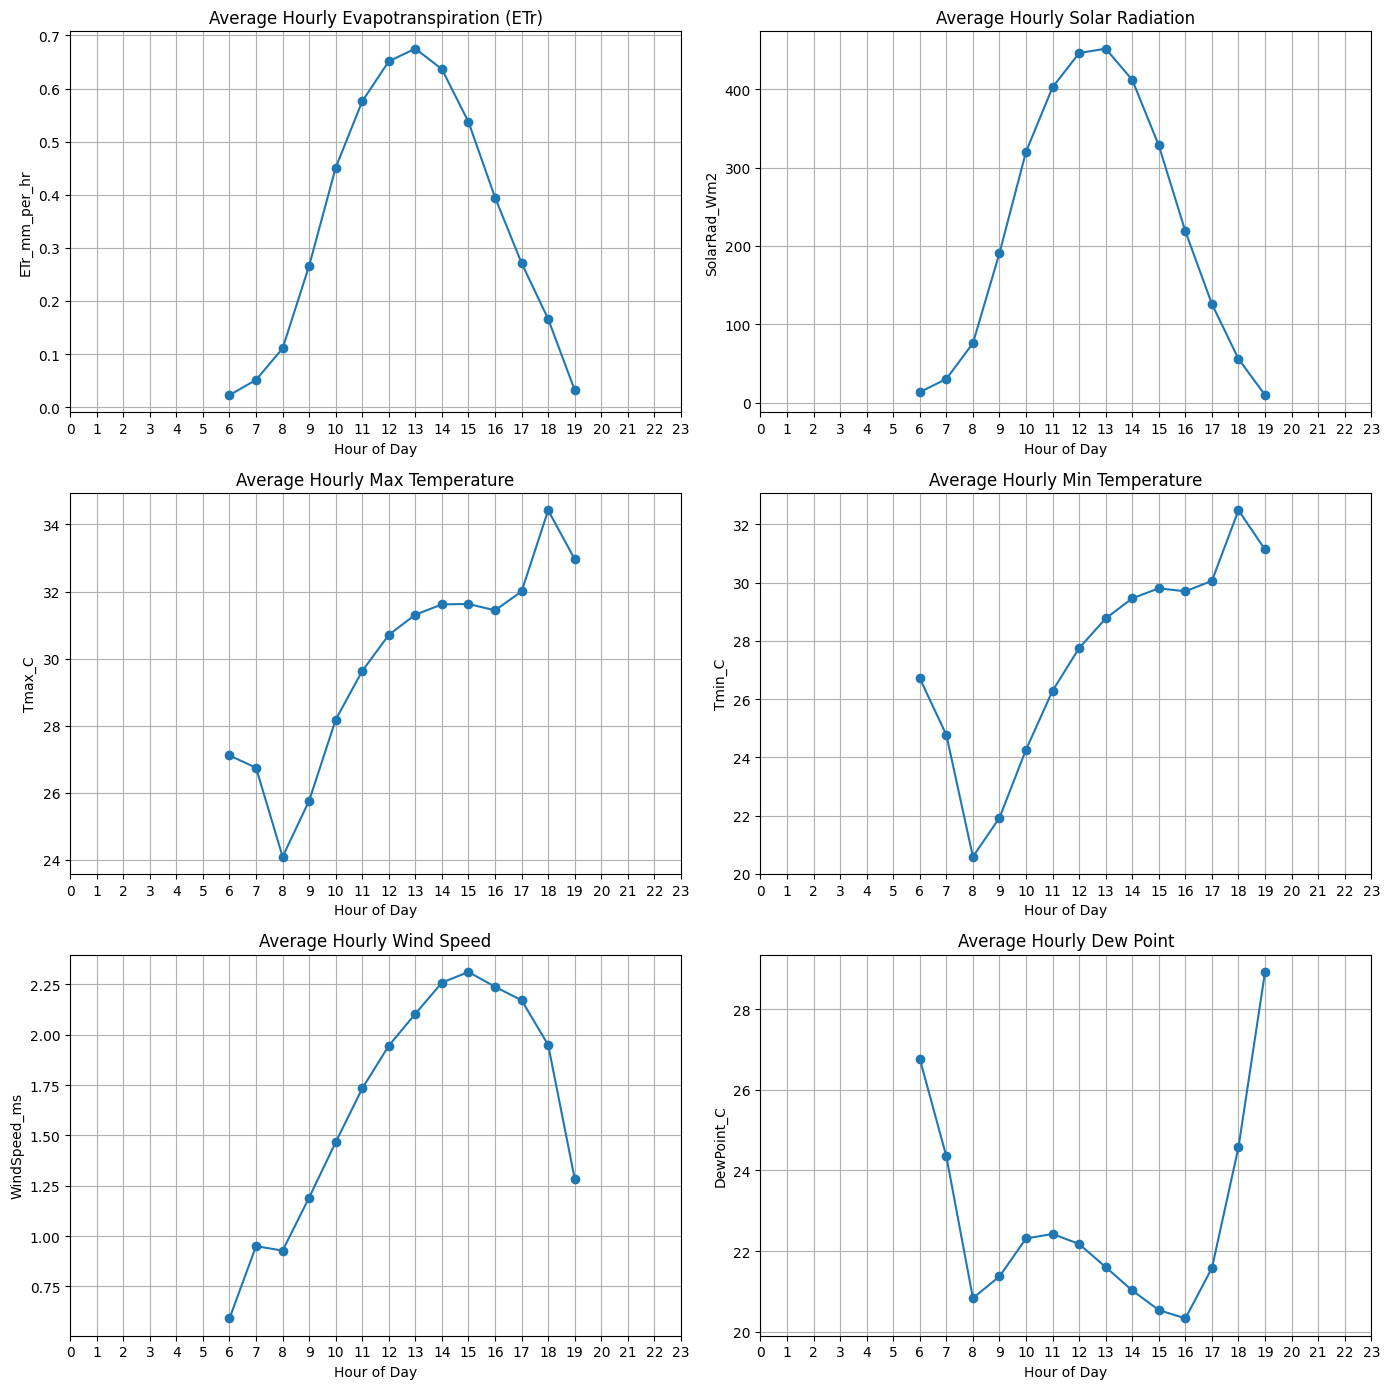

In [115]:
import matplotlib.pyplot as plt

# Extract hour from HourMinute
df['Hour'] = df['HourMinute'] // 100

# Features to plot including ETr
features_to_plot = ['ETr_mm_per_hr', 'SolarRad_Wm2', 'Tmax_C', 'Tmin_C', 'WindSpeed_ms', 'DewPoint_C']
titles = ['Evapotranspiration (ETr)', 'Solar Radiation', 'Max Temperature', 'Min Temperature', 'Wind Speed', 'Dew Point']

# Set up subplot layout: 3 rows x 2 columns
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
axs = axs.flatten()

# Plot each feature
for i, (col, title) in enumerate(zip(features_to_plot, titles)):
    hourly_avg = df.groupby('Hour')[col].mean()
    axs[i].plot(hourly_avg, marker='o')
    axs[i].set_title(f'Average Hourly {title}')
    axs[i].set_xlabel('Hour of Day')
    axs[i].set_ylabel(col)
    axs[i].grid(True)
    axs[i].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

**Cumulative Evapotranspiration**

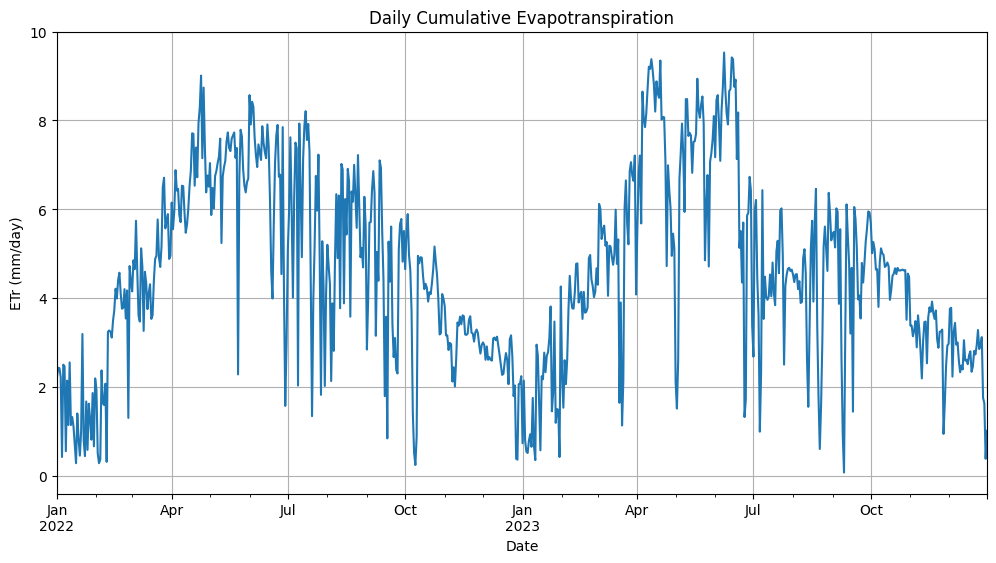

In [109]:
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
daily_etr = df.groupby('Date')['ETr_mm_per_hr'].sum()

plt.figure(figsize=(12, 6))
daily_etr.plot()
plt.title('Daily Cumulative Evapotranspiration')
plt.xlabel('Date')
plt.ylabel('ETr (mm/day)')
plt.grid(True)
plt.show()

**Seasonal Comparison**

<Figure size 1200x700 with 0 Axes>

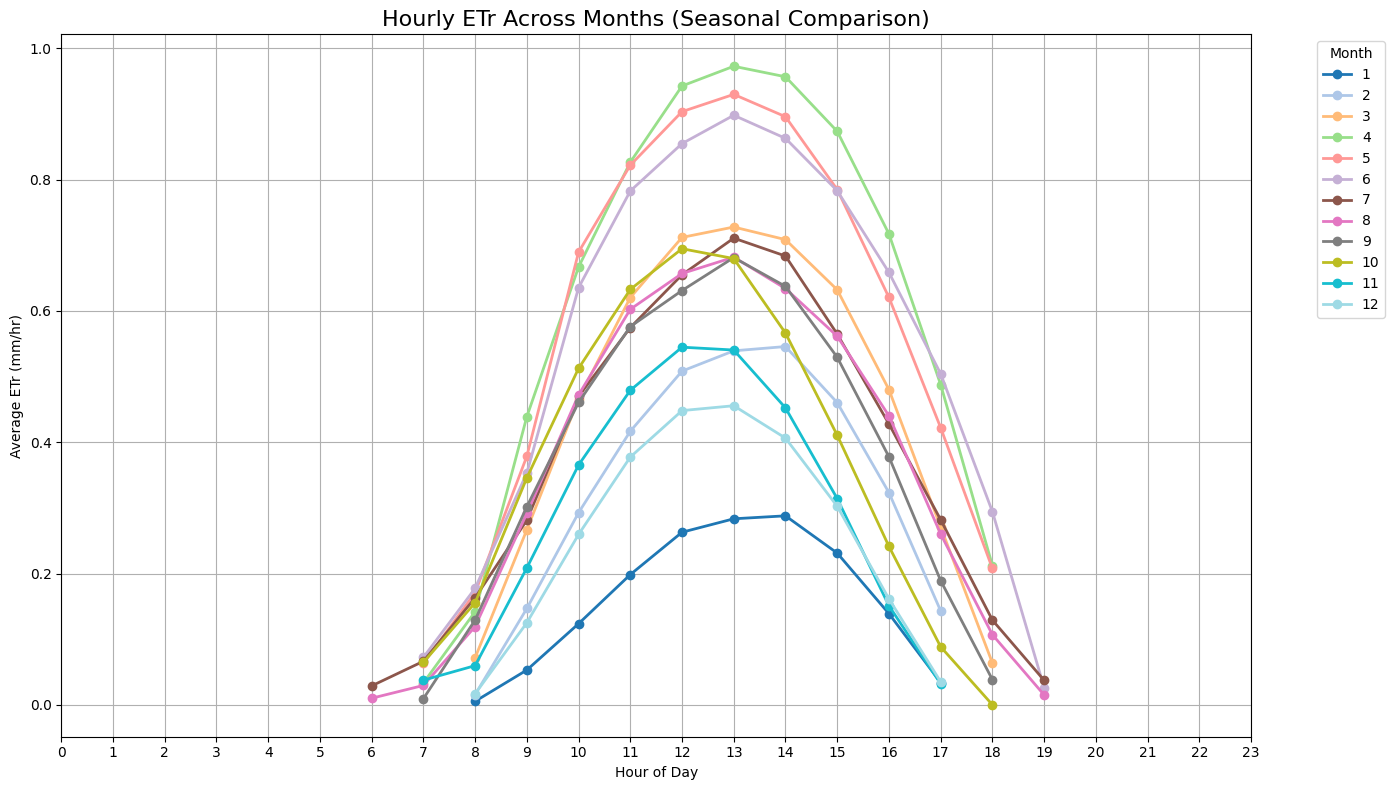

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract hour
df['Hour'] = df['HourMinute'] // 100

# Group by Month and Hour, compute mean ETr
hourly_etr_by_month = df.groupby(['Month', 'Hour'])['ETr_mm_per_hr'].mean().reset_index()

# Pivot for plotting (rows=Hour, cols=Month)
etr_pivot = hourly_etr_by_month.pivot(index='Hour', columns='Month', values='ETr_mm_per_hr')

# Plot
plt.figure(figsize=(12, 7))
etr_pivot.plot(marker='o', figsize=(14, 8), colormap='tab20', linewidth=2)

plt.title('Hourly ETr Across Months (Seasonal Comparison)', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Average ETr (mm/hr)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Machine Learning Models**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [11]:
# Define target and features
X = df.drop(columns=['Month', 'Day', 'DayOfYear', 'Year', 'HourMinute', 'ETr_mm_per_hr'])
y = df['ETr_mm_per_hr']

# Optional: check feature columns
print("Feature Columns:", X.columns.tolist())

Feature Columns: ['Tmax_C', 'Tmin_C', 'SolarRad_Wm2', 'WindSpeed_ms', 'DewPoint_C']


In [12]:
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **ALL PARAMETERS**
Tmin_C, Tmax_C, SolarRad_Wm2, WindSpeed_ms, DewPoint_C



**LINEAR REGRESSION**

In [13]:
# Initialize and fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

In [14]:
# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"R-squared (R² Score): {r2_lr:.4f}")

Mean Squared Error (MSE): 0.0021
R-squared (R² Score): 0.9785


In [15]:
# coefficients
coefficients_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
print(coefficients_lr)

        Feature  Coefficient
0        Tmax_C     0.007993
1        Tmin_C     0.004784
2  SolarRad_Wm2     0.001300
3  WindSpeed_ms     0.012696
4    DewPoint_C    -0.008930


**RANDOM FOREST**

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

In [18]:
# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"R-squared (R² Score): {r2_rf:.4f}")

Mean Squared Error (MSE): 0.0004
R-squared (R² Score): 0.9959


In [19]:
# Feature importances
feature_importances_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_rf)

Feature Importances:
        Feature  Importance
2  SolarRad_Wm2    0.904176
1        Tmin_C    0.036343
0        Tmax_C    0.027654
3  WindSpeed_ms    0.018754
4    DewPoint_C    0.013073


**GRADIENT BOOSTING REGRESSOR**

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

In [22]:
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting - MSE: {mse_gbr:.4f}")
print(f"Gradient Boosting - R²: {r2_gbr:.4f}")

Gradient Boosting - MSE: 0.0006
Gradient Boosting - R²: 0.9941


In [23]:
# Feature importances
feature_importances_gbr = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbr_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_gbr)

Feature Importances:
        Feature  Importance
2  SolarRad_Wm2    0.899893
1        Tmin_C    0.038457
0        Tmax_C    0.030237
4    DewPoint_C    0.015723
3  WindSpeed_ms    0.015690


**SUPPORT VECTOR MACHINE (SVM) REGRESSOR**

In [24]:
from sklearn.svm import SVR
import pandas as pd
from sklearn.inspection import permutation_importance

In [25]:
# Support Vector Machine Regressor
svm_model = SVR()
svm_model.fit(X_train, y_train)
y_pred_svr = svm_model.predict(X_test)

In [26]:
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVM Regressor - MSE: {mse_svr:.4f}, R²: {r2_svr:.4f}")

SVM Regressor - MSE: 0.0024, R²: 0.9747


In [27]:
# Calculate permutation importance
result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for feature importances
feature_importances_svr = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_svr)

Feature Importances:
        Feature  Importance
2  SolarRad_Wm2    1.272601
1        Tmin_C    0.066529
0        Tmax_C    0.057323
4    DewPoint_C    0.056364
3  WindSpeed_ms    0.003606


**XGBOOST REGRESSOR**

In [28]:
import xgboost as xgb

In [29]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [30]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regressor - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGBoost Regressor - MSE: 0.0003, R²: 0.9968


In [31]:
# Feature importances
feature_importances_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_xgb)

Feature Importances:
        Feature  Importance
2  SolarRad_Wm2    0.878679
1        Tmin_C    0.047440
0        Tmax_C    0.034471
4    DewPoint_C    0.020572
3  WindSpeed_ms    0.018839


# **ALL SCATTER PLOTS - All Parameters**

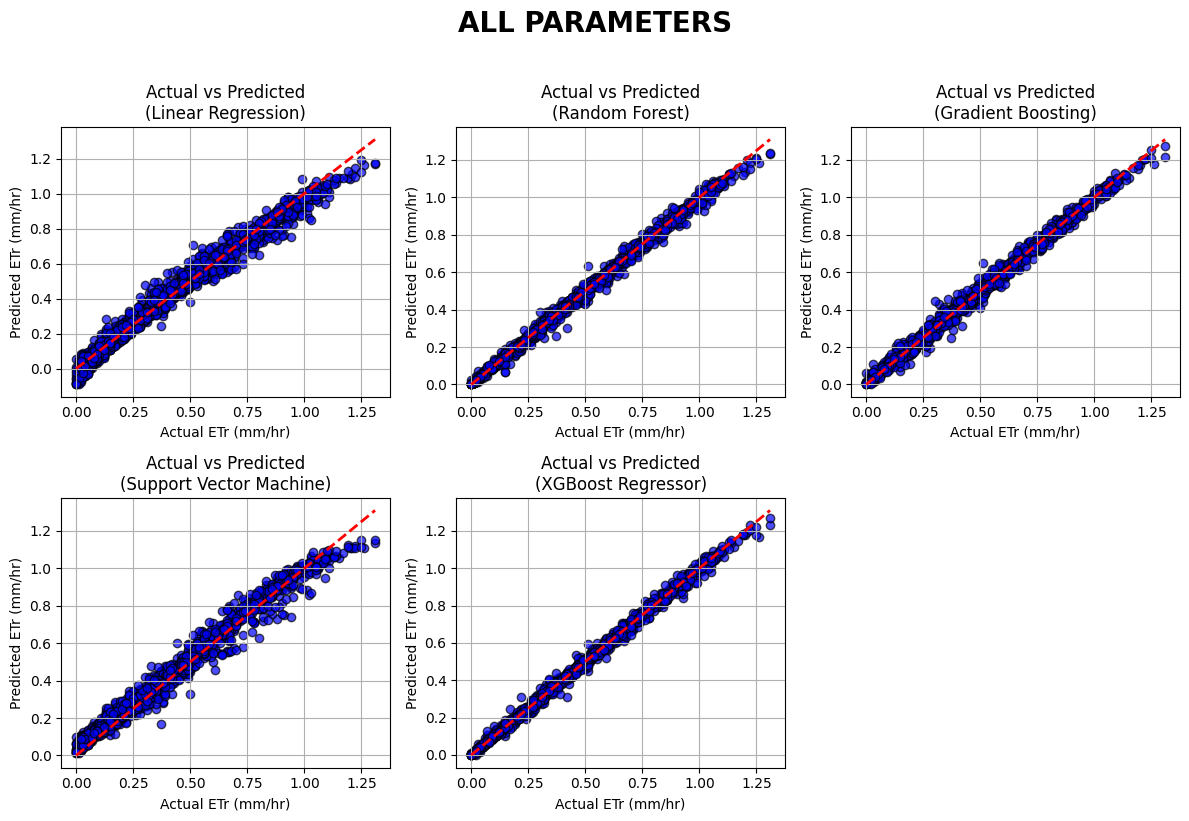

In [32]:
import matplotlib.pyplot as plt

# Define predictions and titles in a list
models = [
    ('Linear Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gbr),
    ('Support Vector Machine', y_pred_svr),
    ('XGBoost Regressor', y_pred_xgb)
]

# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each model and create a subplot
for idx, (model_name, y_pred) in enumerate(models, 1):
    plt.subplot(2, 3, idx)  # 2 rows, 3 columns, plot number idx
    plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual ETr (mm/hr)')
    plt.ylabel('Predicted ETr (mm/hr)')
    plt.title(f'Actual vs Predicted\n({model_name})')
    plt.grid(True)

# Add main title
plt.suptitle('ALL PARAMETERS', fontsize=20, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# **TEMPERATURE**
Tmin_C, Tmax_C

In [33]:
# Define target and features for Temp vs ETr
X_temp = df[['Tmax_C', 'Tmin_C']]  # Only Temp as feature
y_etr = df['ETr_mm_per_hr']  # ETr as target

# Optional: check feature column
print("Feature Columns for Temp:", X_temp.columns.tolist())

Feature Columns for Temp: ['Tmax_C', 'Tmin_C']


In [34]:
# 80% training, 20% testing
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_etr, test_size=0.2, random_state=42)

**LINEAR REGRESSION**

In [35]:
# Initialize and fit the model
lr_model_temp = LinearRegression()
lr_model_temp.fit(X_train_temp, y_train_temp)

# Make predictions
y_pred_temp_lr = lr_model_temp.predict(X_test_temp)

In [36]:
# Evaluate
mse_temp_lr = mean_squared_error(y_test_temp, y_pred_temp_lr)
r2_temp_lr = r2_score(y_test_temp, y_pred_temp_lr)

print(f"Mean Squared Error (MSE): {mse_temp_lr:.4f}")
print(f"R-squared (R² Score): {r2_temp_lr:.4f}")

Mean Squared Error (MSE): 0.0570
R-squared (R² Score): 0.4083


In [37]:
# coefficients
coefficients_temp = pd.DataFrame({
    'Feature': X_temp.columns,
    'Coefficient': lr_model_temp.coef_
})
print(coefficients_temp)

  Feature  Coefficient
0  Tmax_C     0.020882
1  Tmin_C     0.004370


**RANDOM FOREST**

In [38]:
# Initialize and fit the Random Forest model
rf_model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_temp.fit(X_train_temp, y_train_temp)

# Make predictions
y_pred_temp_rf = rf_model_temp.predict(X_test_temp)

In [39]:
# Evaluate
mse_rf_temp = mean_squared_error(y_test_temp, y_pred_temp_rf)
r2_rf_temp = r2_score(y_test_temp, y_pred_temp_rf)

print(f"Mean Squared Error (MSE): {mse_rf_temp:.4f}")
print(f"R-squared (R² Score): {r2_rf_temp:.4f}")

Mean Squared Error (MSE): 0.0604
R-squared (R² Score): 0.3724


In [40]:
# Feature importances
feature_importances_temp_rf = pd.DataFrame({
    'Feature': X_temp.columns,
    'Importance': rf_model_temp.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_temp_rf)

Feature Importances:
  Feature  Importance
0  Tmax_C    0.677381
1  Tmin_C    0.322619


**GRADIENT BOOSTING REGRESSOR**

In [41]:
# Gradient Boosting Regressor
gbr_model_temp = GradientBoostingRegressor(random_state=42)
gbr_model_temp.fit(X_train_temp, y_train_temp)
y_pred_temp_gbr = gbr_model_temp.predict(X_test_temp)

In [42]:
mse_temp_gbr = mean_squared_error(y_test_temp, y_pred_temp_gbr)
r2_temp_gbr = r2_score(y_test_temp, y_pred_temp_gbr)

print(f"Gradient Boosting - MSE: {mse_temp_gbr:.4f}")
print(f"Gradient Boosting - R²: {r2_temp_gbr:.4f}")

Gradient Boosting - MSE: 0.0510
Gradient Boosting - R²: 0.4701


In [43]:
# Feature importances
feature_importances_temp_gbr = pd.DataFrame({
    'Feature': X_temp.columns,
    'Importance': gbr_model_temp.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_temp_gbr)

Feature Importances:
  Feature  Importance
0  Tmax_C    0.816428
1  Tmin_C    0.183572


**SUPPORT VECTOR MACHINE (SVM) REGRESSOR**

In [44]:
from sklearn.svm import SVR
import pandas as pd
from sklearn.inspection import permutation_importance

In [45]:
# Support Vector Machine Regressor
svm_model_temp = SVR()
svm_model_temp.fit(X_train_temp, y_train_temp)
y_pred_temp_svr = svm_model_temp.predict(X_test_temp)

In [46]:
mse_temp_svr = mean_squared_error(y_test_temp, y_pred_temp_svr)
r2_temp_svr = r2_score(y_test_temp, y_pred_temp_svr)

print(f"SVM Regressor - MSE: {mse_temp_svr:.4f}, R²: {r2_temp_svr:.4f}")

SVM Regressor - MSE: 0.0513, R²: 0.4673


In [47]:
# Calculate permutation importance
result = permutation_importance(svm_model_temp, X_test_temp, y_test_temp, n_repeats=10, random_state=42)

# Create a DataFrame for feature importances
feature_importances_temp_svr = pd.DataFrame({
    'Feature': X_temp.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_temp_svr)

Feature Importances:
  Feature  Importance
0  Tmax_C    5.308896
1  Tmin_C    3.173532


**XGBOOST REGRESSOR**

In [48]:
import xgboost as xgb

In [49]:
# XGBoost Regressor
xgb_model_temp = xgb.XGBRegressor(random_state=42)
xgb_model_temp.fit(X_train_temp, y_train_temp)
y_pred_temp_xgb = xgb_model_temp.predict(X_test_temp)

In [50]:
mse_temp_xgb = mean_squared_error(y_test_temp, y_pred_temp_xgb)
r2_temp_xgb = r2_score(y_test_temp, y_pred_temp_xgb)

print(f"XGBoost Regressor - MSE: {mse_temp_xgb:.4f}, R²: {r2_temp_xgb:.4f}")

XGBoost Regressor - MSE: 0.0578, R²: 0.4000


In [51]:
# Feature importances
feature_importances_temp_xgb = pd.DataFrame({
    'Feature': X_temp.columns,
    'Importance': xgb_model_temp.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_temp_xgb)

Feature Importances:
  Feature  Importance
0  Tmax_C    0.773817
1  Tmin_C    0.226183


# **ALL SCATTER PLOTS - Temperature**

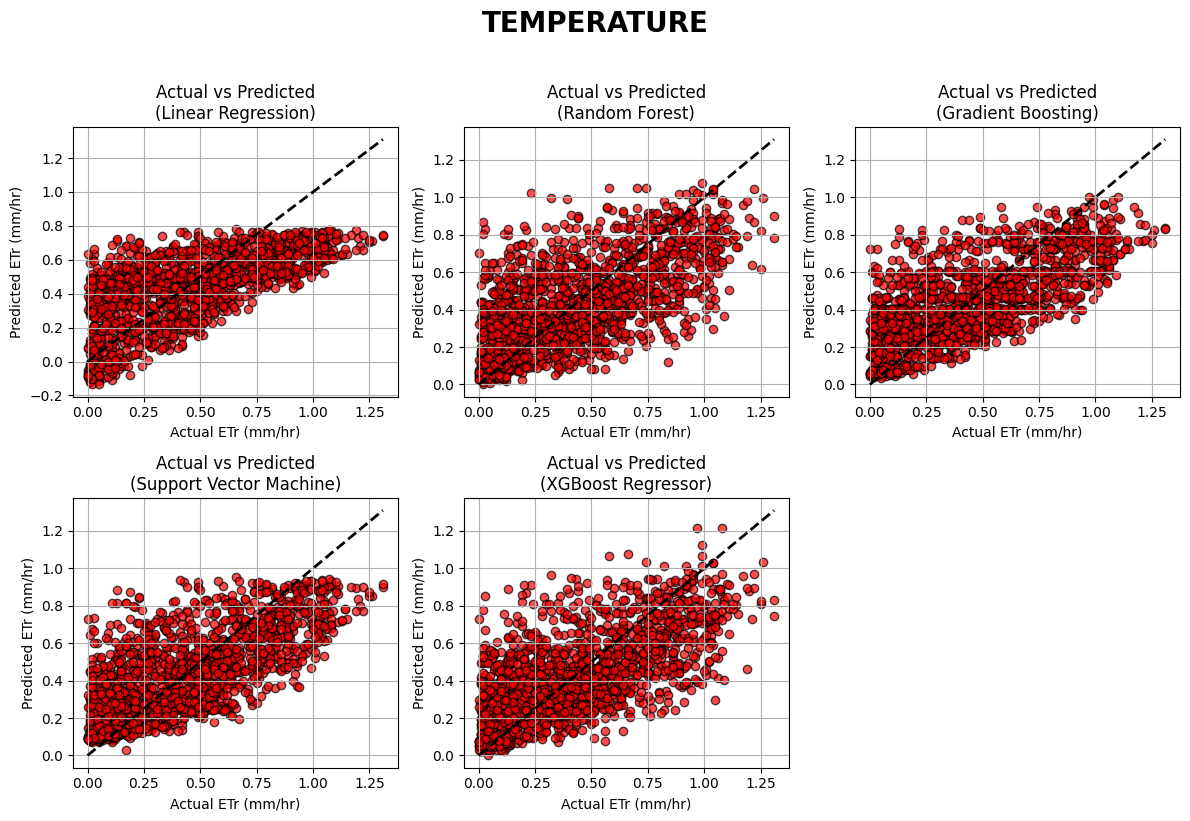

In [52]:
import matplotlib.pyplot as plt

# Define predictions and titles in a list
models = [
    ('Linear Regression', y_pred_temp_lr),
    ('Random Forest', y_pred_temp_rf),
    ('Gradient Boosting', y_pred_temp_gbr),
    ('Support Vector Machine', y_pred_temp_svr),
    ('XGBoost Regressor', y_pred_temp_xgb)
]

# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each model and create a subplot
for idx, (model_name, y_pred_temp) in enumerate(models, 1):
    plt.subplot(2, 3, idx)  # 2 rows, 3 columns, plot number idx
    plt.scatter(y_test_temp, y_pred_temp, color='red', edgecolor='k', alpha=0.7)
    plt.plot([y_test_temp.min(), y_test_temp.max()], [y_test_temp.min(), y_test_temp.max()], color='black', linestyle='--', linewidth=2)
    plt.xlabel('Actual ETr (mm/hr)')
    plt.ylabel('Predicted ETr (mm/hr)')
    plt.title(f'Actual vs Predicted\n({model_name})')
    plt.grid(True)

# Add main title
plt.suptitle('TEMPERATURE', fontsize=20, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# **SOLAR RADIATION**
SolarRad_Wm2

In [53]:
# Define target and features for SolarRad vs ETr
X_Rn = df[['SolarRad_Wm2']]  # Only SolarRad as feature
y_etr = df['ETr_mm_per_hr']  # ETr as target

# Optional: check feature column
print("Feature Columns for SolarRad:", X_Rn.columns.tolist())

Feature Columns for SolarRad: ['SolarRad_Wm2']


In [54]:
# 80% training, 20% testing
X_train_Rn, X_test_Rn, y_train_Rn, y_test_Rn = train_test_split(X_Rn, y_etr, test_size=0.2, random_state=42)

**LINEAR REGRESSION**

In [55]:
# Initialize and fit the model
lr_model_Rn = LinearRegression()
lr_model_Rn.fit(X_train_Rn, y_train_Rn)

# Make predictions
y_pred_Rn_lr = lr_model_Rn.predict(X_test_Rn)

In [56]:
# Evaluate
mse_Rn_lr = mean_squared_error(y_test_Rn, y_pred_Rn_lr)
r2_Rn_lr = r2_score(y_test_Rn, y_pred_Rn_lr)

print(f"Mean Squared Error (MSE): {mse_Rn_lr:.4f}")
print(f"R-squared (R² Score): {r2_Rn_lr:.4f}")

Mean Squared Error (MSE): 0.0109
R-squared (R² Score): 0.8865


In [57]:
# coefficients
coefficients_solarrad = pd.DataFrame({
    'Feature': X_Rn.columns,
    'Coefficient': lr_model_Rn.coef_
})
print(coefficients_solarrad)

        Feature  Coefficient
0  SolarRad_Wm2     0.001517


**RANDOM FOREST**

In [58]:
# Initialize and fit the Random Forest model
rf_model_Rn = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_Rn.fit(X_train_Rn, y_train_Rn)

# Make predictions
y_pred_Rn_rf = rf_model_Rn.predict(X_test_Rn)

In [59]:
# Evaluate
mse_rf_Rn = mean_squared_error(y_test_Rn, y_pred_Rn_rf)
r2_rf_Rn = r2_score(y_test_Rn, y_pred_Rn_rf)

print(f"Mean Squared Error (MSE): {mse_rf_Rn:.4f}")
print(f"R-squared (R² Score): {r2_rf_Rn:.4f}")

Mean Squared Error (MSE): 0.0116
R-squared (R² Score): 0.8794


In [60]:
# Feature importances
feature_importances_Rn_rf = pd.DataFrame({
    'Feature': X_Rn.columns,
    'Importance': rf_model_Rn.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_Rn_rf)

Feature Importances:
        Feature  Importance
0  SolarRad_Wm2         1.0


**GRADIENT BOOSTING REGRESSOR**

In [61]:
# Gradient Boosting Regressor
gbr_model_Rn = GradientBoostingRegressor(random_state=42)
gbr_model_Rn.fit(X_train_Rn, y_train_Rn)
y_pred_Rn_gbr = gbr_model_Rn.predict(X_test_Rn)

In [62]:
mse_Rn_gbr = mean_squared_error(y_test_Rn, y_pred_Rn_gbr)
r2_Rn_gbr = r2_score(y_test_Rn, y_pred_Rn_gbr)

print(f"Gradient Boosting - MSE: {mse_Rn_gbr:.4f}")
print(f"Gradient Boosting - R²: {r2_Rn_gbr:.4f}")

Gradient Boosting - MSE: 0.0106
Gradient Boosting - R²: 0.8895


In [63]:
# Feature importances
feature_importances_Rn_gbr = pd.DataFrame({
    'Feature': X_Rn.columns,
    'Importance': gbr_model_Rn.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_Rn_gbr)

Feature Importances:
        Feature  Importance
0  SolarRad_Wm2         1.0


**SUPPORT VECTOR MACHINE (SVM) REGRESSOR**

In [64]:
from sklearn.svm import SVR
import pandas as pd
from sklearn.inspection import permutation_importance

In [65]:
# Support Vector Machine Regressor
svm_model_Rn = SVR()
svm_model_Rn.fit(X_train_Rn, y_train_Rn)
y_pred_Rn_svr = svm_model_Rn.predict(X_test_Rn)

In [66]:
mse_Rn_svr = mean_squared_error(y_test_Rn, y_pred_Rn_svr)
r2_Rn_svr = r2_score(y_test_Rn, y_pred_Rn_svr)

print(f"SVM Regressor - MSE: {mse_Rn_svr:.4f}, R²: {r2_Rn_svr:.4f}")

SVM Regressor - MSE: 0.0114, R²: 0.8811


In [67]:
# Calculate permutation importance
result = permutation_importance(svm_model_Rn, X_test_Rn, y_test_Rn, n_repeats=10, random_state=42)

# Create a DataFrame for feature importances
feature_importances_Rn_svr = pd.DataFrame({
    'Feature': X_Rn.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_Rn_svr)

Feature Importances:
        Feature  Importance
0  SolarRad_Wm2    1.655409


**XGBOOST REGRESSOR**

In [68]:
import xgboost as xgb

In [69]:
# XGBoost Regressor
xgb_model_Rn = xgb.XGBRegressor(random_state=42)
xgb_model_Rn.fit(X_train_Rn, y_train_Rn)
y_pred_Rn_xgb = xgb_model_Rn.predict(X_test_Rn)

In [70]:
mse_Rn_xgb = mean_squared_error(y_test_Rn, y_pred_Rn_xgb)
r2_Rn_xgb = r2_score(y_test_Rn, y_pred_Rn_xgb)

print(f"XGBoost Regressor - MSE: {mse_Rn_xgb:.4f}, R²: {r2_Rn_xgb:.4f}")

XGBoost Regressor - MSE: 0.0109, R²: 0.8870


In [71]:
# Feature importances
feature_importances_Rn_xgb = pd.DataFrame({
    'Feature': X_Rn.columns,
    'Importance': xgb_model_Rn.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_Rn_xgb)

Feature Importances:
        Feature  Importance
0  SolarRad_Wm2         1.0


# **ALL SCATTER PLOTS - Solar Radiation**

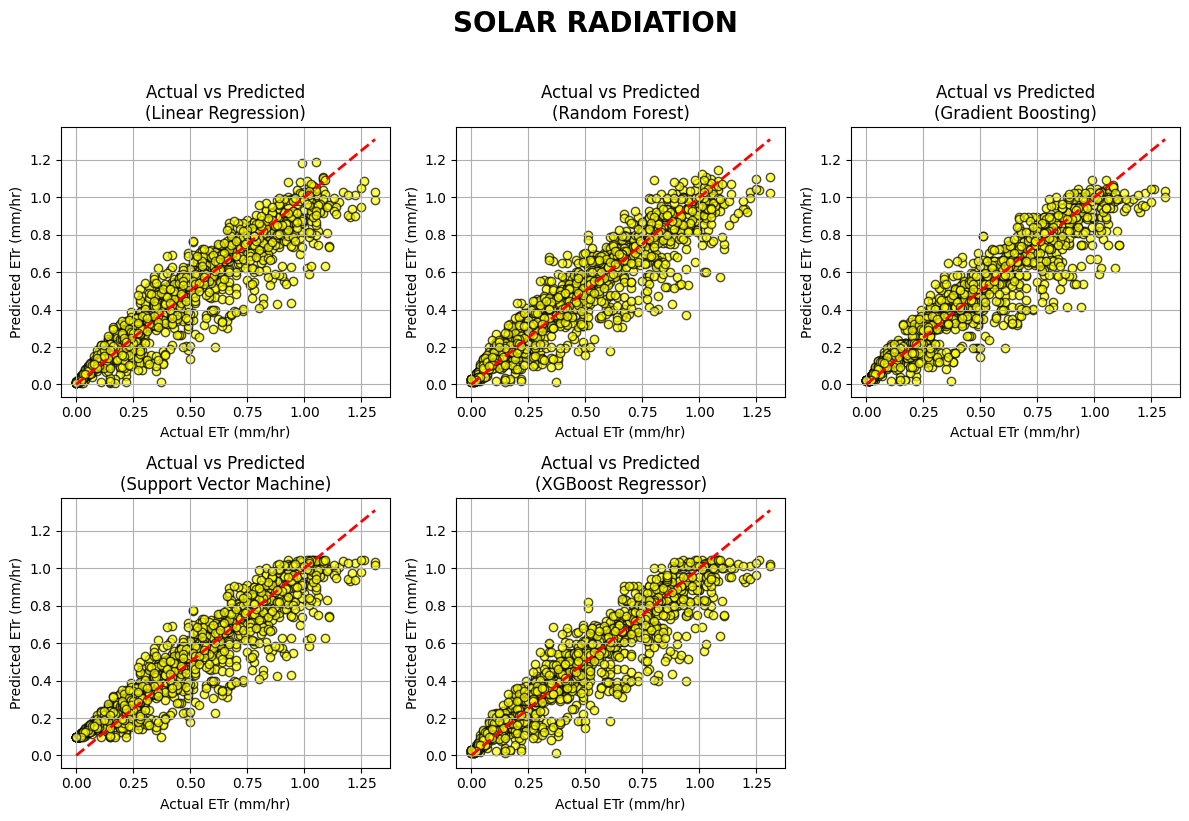

In [72]:
import matplotlib.pyplot as plt

# Define predictions and titles in a list
models = [
    ('Linear Regression', y_pred_Rn_lr),
    ('Random Forest', y_pred_Rn_rf),
    ('Gradient Boosting', y_pred_Rn_gbr),
    ('Support Vector Machine', y_pred_Rn_svr),
    ('XGBoost Regressor', y_pred_Rn_xgb)
]

# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each model and create a subplot
for idx, (model_name, y_pred_Rn) in enumerate(models, 1):
    plt.subplot(2, 3, idx)  # 2 rows, 3 columns, plot number idx
    plt.scatter(y_test_Rn, y_pred_Rn, color='yellow', edgecolor='k', alpha=0.7)
    plt.plot([y_test_Rn.min(), y_test_Rn.max()], [y_test_Rn.min(), y_test_Rn.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual ETr (mm/hr)')
    plt.ylabel('Predicted ETr (mm/hr)')
    plt.title(f'Actual vs Predicted\n({model_name})')
    plt.grid(True)

# Add main title
plt.suptitle('SOLAR RADIATION', fontsize=20, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# **ALL PARAMETERS EXCEPT SOLAR RADIATION**
Tmin_C, Tmax_C, WindSpeed_ms, DewPoint_C

In [73]:
# Define target and features for all parameters except SolarRad vs ETr
X_all = df.drop(columns=['Month', 'Day', 'DayOfYear', 'Year', 'HourMinute', 'SolarRad_Wm2', 'ETr_mm_per_hr'])  # Exclude SolarRad
y_etr = df['ETr_mm_per_hr']  # ETr as target

# Optional: check feature columns
print("Feature Columns (All Except SolarRad):", X_all.columns.tolist())

Feature Columns (All Except SolarRad): ['Tmax_C', 'Tmin_C', 'WindSpeed_ms', 'DewPoint_C']


In [74]:
# 80% training, 20% testing
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_etr, test_size=0.2, random_state=42)

**LINEAR REGRESSION**

In [75]:
# Initialize and fit the model
lr_model_all = LinearRegression()
lr_model_all.fit(X_train_all, y_train_all)

# Make predictions
y_pred_all_lr = lr_model_all.predict(X_test_all)

In [76]:
# Evaluate
mse_all_lr = mean_squared_error(y_test_all, y_pred_all_lr)
r2_all_lr = r2_score(y_test_all, y_pred_all_lr)

print(f"Mean Squared Error (MSE): {mse_all_lr:.4f}")
print(f"R-squared (R² Score): {r2_all_lr:.4f}")

Mean Squared Error (MSE): 0.0480
R-squared (R² Score): 0.5012


In [77]:
# coefficients
coefficients_all = pd.DataFrame({
    'Feature': X_all.columns,
    'Coefficient': lr_model_all.coef_
})
print(coefficients_all)

        Feature  Coefficient
0        Tmax_C     0.026613
1        Tmin_C     0.002045
2  WindSpeed_ms     0.029747
3    DewPoint_C    -0.011951


**RANDOM FOREST**

In [78]:
# Initialize and fit the Random Forest model
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_all.fit(X_train_all, y_train_all)

# Make predictions
y_pred_all_rf = rf_model_all.predict(X_test_all)

In [79]:
# Evaluate
mse_rf_all = mean_squared_error(y_test_all, y_pred_all_rf)
r2_rf_all = r2_score(y_test_all, y_pred_all_rf)

print(f"Mean Squared Error (MSE): {mse_rf_all:.4f}")
print(f"R-squared (R² Score): {r2_rf_all:.4f}")

Mean Squared Error (MSE): 0.0424
R-squared (R² Score): 0.5595


In [80]:
# Feature importances
feature_importances_all_rf = pd.DataFrame({
    'Feature': X_all.columns,
    'Importance': rf_model_all.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_all_rf)

Feature Importances:
        Feature  Importance
0        Tmax_C    0.528800
2  WindSpeed_ms    0.161495
3    DewPoint_C    0.157228
1        Tmin_C    0.152478


**GRADIENT BOOSTING REGRESSOR**

In [81]:
# Gradient Boosting Regressor
gbr_model_all = GradientBoostingRegressor(random_state=42)
gbr_model_all.fit(X_train_all, y_train_all)
y_pred_all_gbr = gbr_model_all.predict(X_test_all)

In [82]:
mse_all_gbr = mean_squared_error(y_test_all, y_pred_all_gbr)
r2_all_gbr = r2_score(y_test_all, y_pred_all_gbr)

print(f"Gradient Boosting - MSE: {mse_all_gbr:.4f}")
print(f"Gradient Boosting - R²: {r2_all_gbr:.4f}")

Gradient Boosting - MSE: 0.0423
Gradient Boosting - R²: 0.5609


In [83]:
# Feature importances
feature_importances_all_gbr = pd.DataFrame({
    'Feature': X_all.columns,
    'Importance': gbr_model_all.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_all_gbr)

Feature Importances:
        Feature  Importance
0        Tmax_C    0.683065
1        Tmin_C    0.117609
2  WindSpeed_ms    0.108451
3    DewPoint_C    0.090875


**SUPPORT VECTOR MACHINE (SVM) REGRESSOR**

In [84]:
from sklearn.svm import SVR
import pandas as pd
from sklearn.inspection import permutation_importance

In [85]:
# Support Vector Machine Regressor
svm_model_all = SVR()
svm_model_all.fit(X_train_all, y_train_all)
y_pred_all_svr = svm_model_all.predict(X_test_all)

In [86]:
mse_all_svr = mean_squared_error(y_test_all, y_pred_all_svr)
r2_all_svr = r2_score(y_test_all, y_pred_all_svr)

print(f"SVM Regressor - MSE: {mse_all_svr:.4f}, R²: {r2_all_svr:.4f}")

SVM Regressor - MSE: 0.0439, R²: 0.5444


In [87]:
# Calculate permutation importance
result = permutation_importance(svm_model_all, X_test_all, y_test_all, n_repeats=10, random_state=42)

# Create a DataFrame for feature importances
feature_importances_all_svr = pd.DataFrame({
    'Feature': X_all.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_all_svr)

Feature Importances:
        Feature  Importance
0        Tmax_C    3.066051
1        Tmin_C    0.872661
3    DewPoint_C    0.486421
2  WindSpeed_ms    0.084074


**XGBOOST REGRESSOR**

In [88]:
import xgboost as xgb

In [89]:
# XGBoost Regressor
xgb_model_all = xgb.XGBRegressor(random_state=42)
xgb_model_all.fit(X_train_all, y_train_all)
y_pred_all_xgb = xgb_model_all.predict(X_test_all)

In [90]:
mse_all_xgb = mean_squared_error(y_test_all, y_pred_all_xgb)
r2_all_xgb = r2_score(y_test_all, y_pred_all_xgb)

print(f"XGBoost Regressor - MSE: {mse_all_xgb:.4f}, R²: {r2_all_xgb:.4f}")

XGBoost Regressor - MSE: 0.0449, R²: 0.5341


In [91]:
# Feature importances
feature_importances_all_xgb = pd.DataFrame({
    'Feature': X_all.columns,
    'Importance': xgb_model_all.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances_all_xgb)

Feature Importances:
        Feature  Importance
0        Tmax_C    0.560742
2  WindSpeed_ms    0.158880
3    DewPoint_C    0.146168
1        Tmin_C    0.134211


# **ALL SCATTER PLOTS - All Parameters Except Solar Radiation**

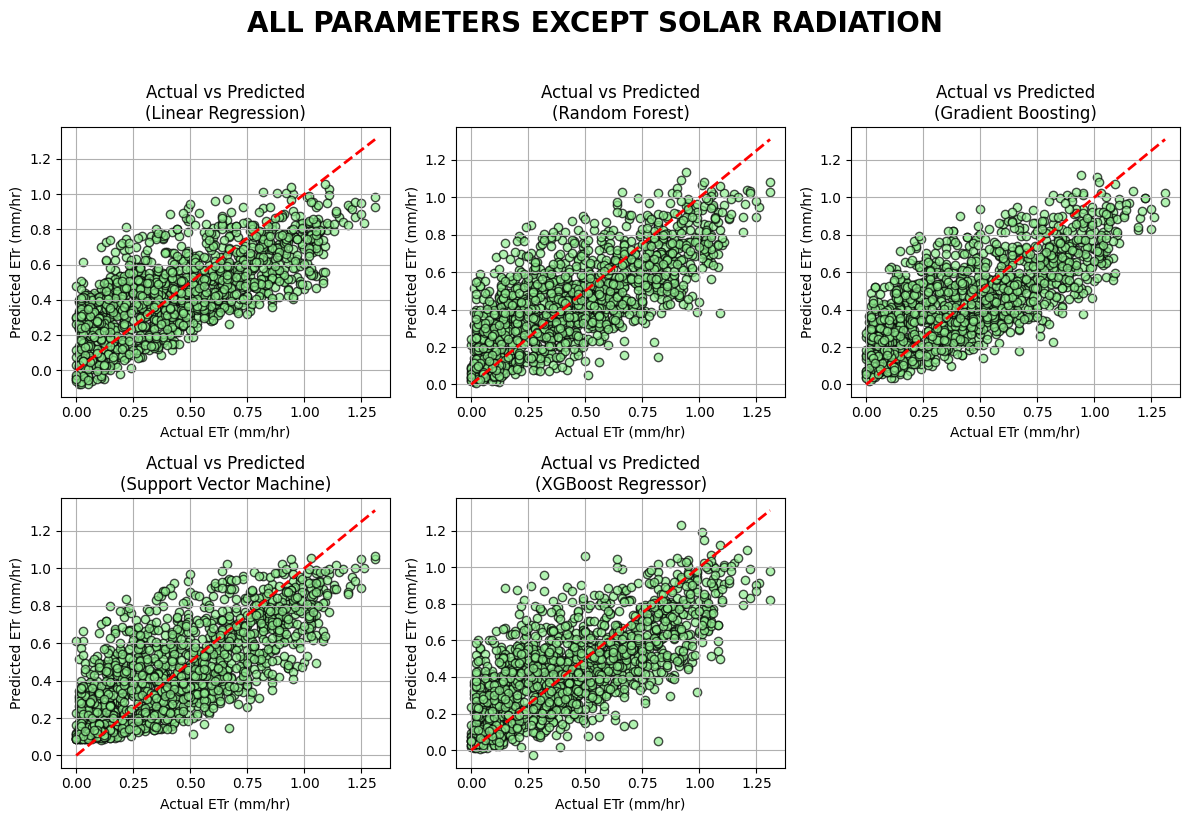

In [92]:
import matplotlib.pyplot as plt

# Define predictions and titles in a list
models = [
    ('Linear Regression', y_pred_all_lr),
    ('Random Forest', y_pred_all_rf),
    ('Gradient Boosting', y_pred_all_gbr),
    ('Support Vector Machine', y_pred_all_svr),
    ('XGBoost Regressor', y_pred_all_xgb)
]

# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each model and create a subplot
for idx, (model_name, y_pred_all) in enumerate(models, 1):
    plt.subplot(2, 3, idx)  # 2 rows, 3 columns, plot number idx
    plt.scatter(y_test_all, y_pred_all, color='lightgreen', edgecolor='k', alpha=0.7)
    plt.plot([y_test_all.min(), y_test_all.max()], [y_test_all.min(), y_test_all.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual ETr (mm/hr)')
    plt.ylabel('Predicted ETr (mm/hr)')
    plt.title(f'Actual vs Predicted\n({model_name})')
    plt.grid(True)

# Add main title
plt.suptitle('ALL PARAMETERS EXCEPT SOLAR RADIATION', fontsize=20, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# **CROSS-VALIDATION**

In [93]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pandas as pd

In [94]:
# Define K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define custom scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # sklearn negates MSE
r2_scorer = make_scorer(r2_score)

In [95]:
# Define your models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVM': SVR(),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

# Define your feature sets
feature_sets = {
    'All Parameters': (X, y),
    'Temperature': (X_temp, y),
    'Solar Radiation': (X_Rn, y),
    'All Parameters Except Solar Radiation': (X_all, y)
}

In [96]:
# Dictionary to store validation results
validation_results = {}

# Loop through each model
for model_name, model in models.items():
    # For each feature set (scenario)
    for feature_set_name, (X_feature, y_feature) in feature_sets.items():
        # Cross-validate MSE
        mse_scores = cross_val_score(model, X_feature, y_feature, cv=kf, scoring=mse_scorer)
        mse_scores = -mse_scores  # negate because sklearn returns negative MSE

        # Cross-validate R²
        r2_scores = cross_val_score(model, X_feature, y_feature, cv=kf, scoring=r2_scorer)

        # Save into dictionary
        validation_results[(model_name, 'MSE', feature_set_name)] = mse_scores.mean()
        validation_results[(model_name, 'R²', feature_set_name)] = r2_scores.mean()

In [97]:
# Convert dictionary to DataFrame
validation_df = pd.DataFrame(validation_results, index=[0]).T
validation_df.columns = ['Mean Score']
validation_df = validation_df.unstack(level=1).swaplevel(0, 1, axis=1).sort_index(axis=1)

# Display
print(validation_df)

                                                               MSE         R²
                                                        Mean Score Mean Score
Gradient Boosting All Parameters                          0.000587   0.993610
                  All Parameters Except Solar Radiation   0.041980   0.543606
                  Solar Radiation                         0.008845   0.904033
                  Temperature                             0.049795   0.458818
Linear Regression All Parameters                          0.001844   0.979958
                  All Parameters Except Solar Radiation   0.047074   0.488500
                  Solar Radiation                         0.009029   0.902055
                  Temperature                             0.055023   0.402255
Random Forest     All Parameters                          0.000400   0.995653
                  All Parameters Except Solar Radiation   0.041100   0.553267
                  Solar Radiation                         0.0098

# **EVALUATION METRICS**

In [98]:
import pandas as pd

In [99]:
# Create a dictionary for the data
data = {
    ('Linear Regression', 'MSE'): [mse_lr, mse_temp_lr, mse_Rn_lr, mse_all_lr],
    ('Linear Regression', 'R²'): [r2_lr, r2_temp_lr, r2_Rn_lr, r2_all_lr],

    ('Random Forest', 'MSE'): [mse_rf, mse_rf_temp, mse_rf_Rn, mse_rf_all],
    ('Random Forest', 'R²'): [r2_rf, r2_rf_temp, r2_rf_Rn, r2_rf_all],

    ('Gradient Boosting', 'MSE'): [mse_gbr, mse_temp_gbr, mse_Rn_gbr, mse_all_gbr],
    ('Gradient Boosting', 'R²'): [r2_gbr, r2_temp_gbr, r2_Rn_gbr, r2_all_gbr],

    ('SVM', 'MSE'): [mse_svr, mse_temp_svr, mse_Rn_svr, mse_all_svr],
    ('SVM', 'R²'): [r2_svr, r2_temp_svr, r2_Rn_svr, r2_all_svr],

    ('XGBoost', 'MSE'): [mse_xgb, mse_temp_xgb, mse_Rn_xgb, mse_all_xgb],
    ('XGBoost', 'R²'): [r2_xgb, r2_temp_xgb, r2_Rn_xgb, r2_all_xgb]
}

In [100]:
# Define the index (rows)
index = ['All Parameters', 'Temperature', 'Solar Radiation', 'All Parameters Except Solar Radiation']

# Create the DataFrame
evaluation_table = pd.DataFrame(data, index=index)

# Display the table
pd.set_option('display.max_columns', None)
evaluation_table

Linear Regression            \
                                                    MSE        R²   
All Parameters                                 0.002072  0.978476   
Temperature                                    0.056965  0.408271   
Solar Radiation                                0.010929  0.886474   
All Parameters Except Solar Radiation          0.048014  0.501244   

                                      Random Forest            \
                                                MSE        R²   
All Parameters                             0.000392  0.995925   
Temperature                                0.060422  0.372354   
Solar Radiation                            0.011614  0.879359   
All Parameters Except Solar Radiation      0.042405  0.559509   

                                      Gradient Boosting                 SVM  \
                                                    MSE        R²       MSE   
All Parameters                                 0.000571  0.994071  0.002435   
Temperature                                    0.051012  0.470104  0.051281   
Solar Radiation                                0.010641  0.889470  0.011444   
All Parameters Except Solar Radiation          0.042272  0.560891  0.043856   

                                                  XGBoost            
                                             R²       MSE        R²  
All Parameters                         0.974707  0.000305  0.996834  
Temperature                            0.467312  0.057762  0.399984  
Solar Radiation                        0.881124  0.010878  0.887000  
All Parameters Except Solar Radiation  0.544434  0.044854  0.534072